# This notebook applies both classifiers on the e-mails data to categorize them and assess the performance (customer engagement) of each category

## Libraries importations

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pk
import seaborn as sns

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag, ngrams, tokenize
sns.set_style('whitegrid')

## Importation of the classifiers and the dataset

In [3]:
## Load both classifiers
formality_classifier = pk.load(open('formality_classifier/model/linguistic_stats_NB.pk', 'rb'))
sentiment_classifier = load_model('sentiment_classifier/sentiment_classifier_final.h5')

## Load any other elements needed to apply the classifiers
tokenizer = pk.load(open('sentiment_classifier/tokenizer.pkl','rb'))

In [77]:
## Load the emails dataset
df_emails = pk.load(open('data/df_emails.pk','rb'))

In [5]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   campaign title            83 non-null     object
 1   hotel                     83 non-null     object
 2   total number of delivers  83 non-null     int64 
 3   unique opens              83 non-null     int64 
 4   unique clicks             83 non-null     int64 
 5   html__url                 83 non-null     object
 6   text_content              83 non-null     object
dtypes: int64(3), object(4)
memory usage: 4.7+ KB


In [15]:
df_emails.iloc[3:4]

,campaign title,hotel,total number of delivers,unique opens,unique clicks,html__url,text_content
3,Apex - London - Mix of offers - Promo - Generi...,Apex,2208,710,12,https://newsapexhotels.co.uk/t/17UA-5QCB3-C885...,"[Burgers, beers, bubbles and balls 🍔 🍻 ⚽ Engla..."


## Preparation of the e-mails data to be able to apply both models

In [6]:
## Preparation for the formality classifier

# we need to compute the linguistic features of each e-mail sentence before applying the formality classifier

# import the part of the formality classifier script we need
##Intermediary functions

def get_case(string):
    """
    return a number list containing: the number of entirely-capitalized words; binary indicator for whether sentence
    is lowercase; binary indicator for whether the first word is capitalized.
    """
    return [len([w for w in word_tokenize(string) if w.isupper()]), int(string.islower()), int(string[0].isupper())]

def get_lexical(string):
    """
    return the number of contractions in the sentence, normalized by length; average word length; average word
    log-frequency according to Google Ngram corpus; average formality score as computed by Pavlick and
    Nenkova (2015).
    """
    # prepare
    output = []
    tokens = word_tokenize(string.lower())
    length = len(tokens)

    # 1. number of contractions, norm by length
    cont_count = 0
    for w in tokens:
        if "\'" in w and len(w) > 1:
            cont_count += 1
    output.append(round(cont_count/length, 2))

    # 2. average word length
    output.append(round(sum([len(w) for w in tokens])/length, 2))
    
    return output
    
def get_punctuation_number(string):
    """
    punctuation Number of ‘?’, ‘...’, and ‘!’ in the sentence.
    """
    punct_number = 0
    tokens = word_tokenize(string)

    for w in tokens:
        if w in ["?", "...", "!", ";"]:
            punct_number += 1
    return [punct_number]


## Final function gathering all those stats and computing them on a sentence level

def get_linguistic_features_sentence(string):
    # get the easier-to-compute features
    output = []
    # 3 nums
    output.extend(get_case(string))
    # 2 nums
    output.extend(get_lexical(string))
    # 1 num
    output.extend(get_punctuation_number(string))

    # total of 6 nums per input sentence
    return output

##FINAL FUNCTION that gets applied on an e-mail level (list of sentences)

def get_linguistic_features_all(sent_list):
    """
    return an array of an array of features for the total sentence list
    """
    # get list of raw number stats for each sentence
    num_lists = []
    for s in sent_list:
        num_lists.append(get_linguistic_features_sentence(s))
    # list into vec array
    output = np.array(num_lists)
    return output

In [7]:
## Preparation for the sentiment classifier

# process the email sentence list 
def preprocess_sentiment(sentence_list):
    sequences = tokenizer.texts_to_sequences(sentence_list)
    word_index = tokenizer.word_index
    data_int = pad_sequences(sequences, padding='pre', maxlen=(25))
    data = pad_sequences(data_int, padding='post', maxlen=(30))
    return data


## Applications onto the e-mails dataset

 Some functions are still needed to compute the weighted average of the predictions for each e-mail ( e-mail = weighted sum of sentences)

In [8]:
# formality weighted average
def formality_score_email(email_sent_list, classifier):
    results = []
    title = email_sent_list[0]
    features = get_linguistic_features_all(email_sent_list)
    proba_arrays = classifier.predict_proba(features) ##the array of the prediction probabilities for every sentence
    results.append((title, proba_arrays.mean(axis=0)[1]))
    return results

In [16]:
# test of the formality classifier
test = df_emails['text_content'][3]
res = formality_score_email(test, formality_classifier)
print(f"The formality score of e-mail '{res[0][0]}' is {round(res[0][1],2)}")

The formality score of e-mail 'Burgers, beers, bubbles and balls 🍔 🍻 ⚽ England VS Columbia tonight at our top spots Forward this email to a friend View in browser SUN'S OUT, BUNS AND BALLS OUT ☀ ️ 🍔 ⚽ It’s official.' is 0.34


In [94]:
# sentiment analysis classifier weighted average
def sentiment_label_email(email_sent_list, classifier):
    classes = ['Serious', 'Happy', 'Fun', 'Caring']
    res = {i: 0 for i in range(len(classes))}
    
    X_test = preprocess_sentiment(email_sent_list)
    y_pred = classifier.predict(X_test)   #the predictions are one-hot encoded vectors
    y_pred_label = np.argmax(y_pred, axis=1)
    
    for i in range(len(email_sent_list)):
        if y_pred_label[i] != 0:
            res[y_pred_label[i]] += 1
        else:
            res[y_pred_label[i]] += 0.4
    L = list(res.values())
    most_prob_label =L.index(max(L))
    
    return res, classes[most_prob_label]

In [95]:
# test of the sentiment classifier
test = df_emails['text_content'][3]
res = sentiment_label_email(test, sentiment_classifier)
print(f"The sentiment analysis gives out the following proba of '{res[0]}' , so the label is {res[1]}")

The sentiment analysis gives out the following proba of '{0: 3.9999999999999996, 1: 4, 2: 2, 3: 3}' , so the label is Happy


### Additional tests to observe if the sentiment classification is relevant on e-mails

In [96]:
def chained_tests(n):
    for i in range(0,n):
        test = df_emails[df_emails['hotel']=='Crieff Hydro'].reset_index()
        test = test['text_content'][i]
        res = sentiment_label_email(test, sentiment_classifier)
        print(f"The sentiment analysis gives out the following proba of '{res[0]}' , so the label is {res[1]}")
    return 

chained_tests(20)

The sentiment analysis gives out the following proba of '{0: 3.1999999999999997, 1: 2, 2: 4, 3: 2}' , so the label is Fun
The sentiment analysis gives out the following proba of '{0: 3.9999999999999996, 1: 7, 2: 2, 3: 6}' , so the label is Happy
The sentiment analysis gives out the following proba of '{0: 5.6000000000000005, 1: 2, 2: 4, 3: 4}' , so the label is Serious
The sentiment analysis gives out the following proba of '{0: 5.6000000000000005, 1: 2, 2: 4, 3: 4}' , so the label is Serious
The sentiment analysis gives out the following proba of '{0: 2.8, 1: 2, 2: 4, 3: 2}' , so the label is Fun
The sentiment analysis gives out the following proba of '{0: 3.9999999999999996, 1: 6, 2: 2, 3: 6}' , so the label is Happy
The sentiment analysis gives out the following proba of '{0: 5.6000000000000005, 1: 4, 2: 3, 3: 6}' , so the label is Caring
The sentiment analysis gives out the following proba of '{0: 4.8, 1: 2, 2: 4, 3: 6}' , so the label is Caring
The sentiment analysis gives out the

### Adding columns of formality score and sentiment label in the dataset

In [97]:
df_emails['formality_score'] = df_emails['text_content'].apply(lambda x: formality_score_email(x, formality_classifier)[0][1])
df_emails['sentiment_label'] = df_emails['text_content'].apply(lambda x: sentiment_label_email(x, sentiment_classifier)[1])

In [98]:
df_emails['sentiment_label'].value_counts()

Serious    29
Happy      21
Fun        19
Caring     14
Name: sentiment_label, dtype: int64

In [99]:
df_emails['formality_score'].describe()

count    83.000000
mean      0.338156
std       0.060051
min       0.234455
25%       0.300136
50%       0.335490
75%       0.354296
max       0.522179
Name: formality_score, dtype: float64

## Plotting of the relation between customer engagement and formality + sentiment 

We decide to look at each hotel individually, since there's no point in seeing how different emails perform if they come from other hotels. Indeed, there are too many other variables changing (different clients, different staff, different standards of room, different locations) to argue that the engagement change is simply due to formality or sentiment.

In [100]:
## add some normalized metric to be able to compare customer engagement from one email to another
df_emails['open_rate'] = (df_emails['unique opens']/df_emails['total number of delivers'])*100
df_emails['click_to_open_rate'] = (df_emails['unique clicks']/df_emails['unique opens'])*100

In [101]:
df_emails.head()

,campaign title,hotel,total number of delivers,unique opens,unique clicks,html__url,text_content,formality_score,sentiment_label,open_rate,click_to_open_rate
0,Waterloo Place_autumn promo email_opred in to ...,Apex,1884,812,105,https://newsapexhotels.co.uk/t/17UA-5U6OI-C885...,"[Play hard, nap hard | This Autumn at Waterloo...",0.327504,Serious,43.099788,12.931034
1,Waterloo Place_autumn promo email_27Aug18,Apex,8264,3757,507,https://newsapexhotels.co.uk/t/17UA-5TUDG-C885...,"[Play hard, nap hard | This Autumn at Waterloo...",0.327504,Serious,45.462246,13.494810
2,Apex - Dundee - Mix of offers - Promo -VADUNDE...,Apex,2988,1505,56,https://newsapexhotels.co.uk/t/17UA-5SNCI-C885...,[My V&A Dundee - the latest entry READ ON TO F...,0.398476,Serious,50.368139,3.720930
3,Apex - London - Mix of offers - Promo - Generi...,Apex,2208,710,12,https://newsapexhotels.co.uk/t/17UA-5QCB3-C885...,"[Burgers, beers, bubbles and balls 🍔 🍻 ⚽ Engla...",0.342089,Happy,32.155797,1.690141
4,Apex - Group - Gift Vouchers - Promo - Any Col...,Apex,34174,4825,289,https://newsapexhotels.co.uk/t/17UA-5ICIV-C885...,"[👩 15% off Mother's Day vouchers SPA VOUCHERS,...",0.415050,Serious,14.118921,5.989637


In [102]:
df_emails['hotel'].value_counts()

Crieff Hydro        23
Qhotels             22
Apex                21
Town and Country    17
Name: hotel, dtype: int64

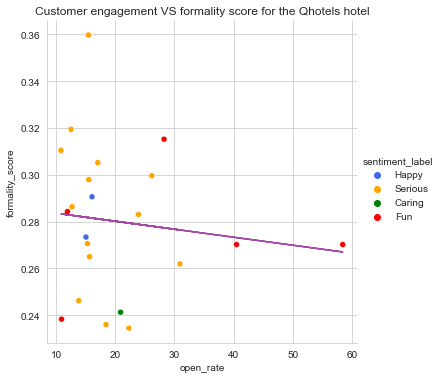

In [135]:
def plots_by_hotel(df_emails, hotel_name):
    df_hotel = df_emails[df_emails['hotel']==hotel_name]
    p1 = sns.relplot(data = df_hotel, x = 'open_rate', y = 'formality_score', hue='sentiment_label', 
                     palette = {'Happy':'royalblue','Serious':'orange','Caring': 'green', 'Fun':'red'})
    #sns.relplot(data = df_hotel, x = 'click_to_open_rate', y = 'formality_score', hue='sentiment_label')
    
    b, a = np.polyfit(df_hotel['open_rate'], df_hotel['formality_score'], 1)
    ax = p1.axes[0,0]
    ax.plot(df_hotel['open_rate'], a + b*df_hotel['open_rate'], '-', color ='purple', alpha = 0.7)
                            
    plt.title(f'Customer engagement VS formality score for the {hotel_name} hotel')
    plt.show()
    return 

plots_by_hotel(df_emails,'Qhotels')

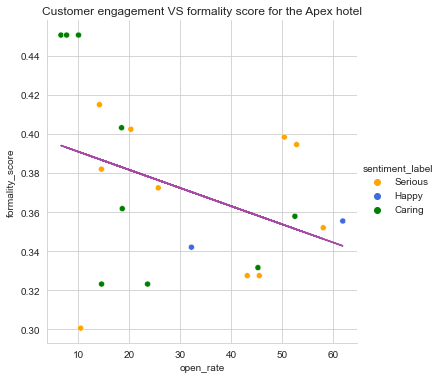

In [136]:
plots_by_hotel(df_emails,'Apex')

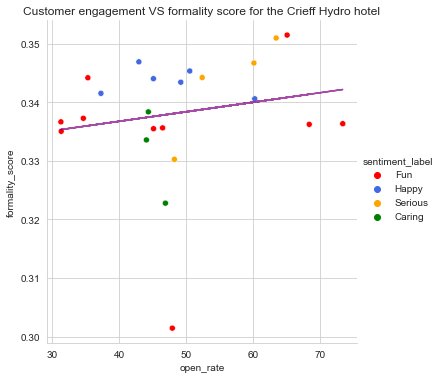

In [137]:
plots_by_hotel(df_emails,'Crieff Hydro')

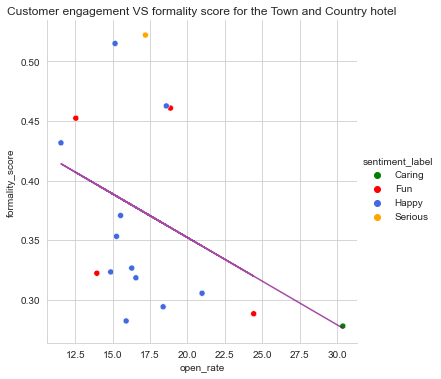

In [138]:
plots_by_hotel(df_emails,'Town and Country')